In [1]:
# import the necessary libraries
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential 
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import os

import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.keras.utils.disable_interactive_logging()


import numpy as np
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-dataset/lingSpam.csv
/kaggle/input/email-spam-dataset/enronSpamSubset.csv
/kaggle/input/email-spam-dataset/completeSpamAssassin.csv
/kaggle/input/spam-email/spam.csv


In [3]:
df = pd.read_csv('/kaggle/input/email-spam-dataset/completeSpamAssassin.csv')

In [4]:
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [5]:
df['Body'].size

6046

In [6]:
df["Label"].value_counts()

Label
0    4150
1    1896
Name: count, dtype: int64

In [7]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
gpus


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
#tf.debugging.set_log_device_placement(True)

In [9]:
for i in range(len(df['Body'])):
    if type(df['Body'][i] != str):
        df['Body'][i] = str(df['Body'][i])

In [10]:
df['Body']

0       \nSave up to 70% on Life Insurance.\nWhy Spend...
1       1) Fight The Risk of Cancer!\nhttp://www.adcli...
2       1) Fight The Risk of Cancer!\nhttp://www.adcli...
3       ##############################################...
4       I thought you might like these:\n1) Slim Down ...
                              ...                        
6041                                                empty
6042                      ___           ___           ...
6043    IN THIS ISSUE:01. Readers write\n02. Extension...
6044                                                empty
6045                                                empty
Name: Body, Length: 6046, dtype: object

In [11]:
maxlen = 100
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Body'])

# Convert the text data to sequences of integers
sequences = tokenizer.texts_to_sequences(df['Body'])

# Get the word index (Dictionary mapping words to their integer indices)
word_index = tokenizer.word_index
print('Found ', len(word_index), ' unique tokens.')

label_encoder = preprocessing.LabelEncoder()
classification = label_encoder.fit_transform(df['Label'])

# Pad sequences to ensure uniform length
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(classification)
print('Shape of the tensor containing the emails:', data.shape)
print('Shape of the tensor containing the classifcation labels:', labels.shape)


Found  73360  unique tokens.
Shape of the tensor containing the emails: (6046, 100)
Shape of the tensor containing the classifcation labels: (6046,)


In [12]:
from sklearn.model_selection import train_test_split

training_samples = int(0.8 * len(df['Body']))
validation_samples = int(0.1 * len(df['Body']))
testing_samples = int(0.1 * len(df['Body']))


# Shuffle and split the data
x_train, x_temp, y_train, y_temp = train_test_split(data, labels, test_size=(validation_samples + testing_samples), random_state=42)

# Split the remaining data into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=testing_samples, random_state=42)

# Print the sizes of the sets
print("Training set size:", len(x_train))
print("Validation set size:", len(x_val))
print("Test set size:", len(x_test))


Training set size: 4838
Validation set size: 604
Test set size: 604


In [13]:
import logging
logging.getLogger('tensorflow').disabled = True


In [14]:
VOC_SIZE = len(tokenizer.word_index)+1

# Function to create the LSTM model
def create_lstm_model(units=100, dropout_rate=0.4, dense_units=20, dense_dropout_rate=0.5, lstm_activation='tanh', dense_activation='relu'):
    model = Sequential()
    model.add(Embedding(VOC_SIZE, 32, input_length=maxlen))
    model.add(LSTM(units, activation=lstm_activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation=dense_activation))
    model.add(Dropout(dense_dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

# hyperparameters
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.3, 0.45],
    'dense_units': [10, 20],
    'dense_dropout_rate': [0.5, 0.6],
    'lstm_activation': ['tanh', 'relu'],
    'dense_activation': ['relu', 'sigmoid']
}

# Placeholder for the best model and accuracy
best_model = None
best_accuracy = 0

# Iterate through hyperparameter combinations
for unit in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for dense_unit in param_grid['dense_units']:
            for dense_dropout_rate in param_grid['dense_dropout_rate']:
                for lstm_activation in param_grid['lstm_activation']:
                    for dense_activation in param_grid['dense_activation']:
                        # Create and compile the model
                        model = create_lstm_model(
                            units=unit,
                            dropout_rate=dropout_rate,
                            dense_units=dense_unit,
                            dense_dropout_rate=dense_dropout_rate,
                            lstm_activation=lstm_activation,
                            dense_activation=dense_activation
                        )

                        # Train the model
                        history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), verbose=0)
                        # Get the validation accuracy
                        val_accuracy = history.history['val_acc'][-1]

                        print(f'Validation Accuracy: {val_accuracy:.4f}, Params: {model.get_config()}')
                        # Update the best model if the current one is better
                        if val_accuracy > best_accuracy:
                            best_accuracy = val_accuracy
                            best_model = model

print("Best Accuracy:", best_accuracy)
print(f'Best Validation Accuracy: {best_accuracy:.4f}, Params: {best_model.get_config()}')

Validation Accuracy: 0.9669, Params: {'name': 'sequential', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 100), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'embedding_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'embedding', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 100), 'input_dim': 73361, 'output_dim': 32, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': 100}, 'registered_name': None, 'build_config': {'input_shape': (None, 100)}}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm', 'trainable': True, 'dtype': 'float32', 'return_sequences': False, 

In [15]:
np.savetxt('email_train.csv', x_train, delimiter=',')
np.savetxt('email_val.csv', x_val, delimiter=',')
np.savetxt('email_test.csv', x_test, delimiter=',')

In [16]:
values_2 = best_model.evaluate(x_test,y_test)

In [18]:
y_pred=best_model.predict(x_test)
y_pred=(y_pred>0.5)

In [19]:
from sklearn.metrics import accuracy_score,confusion_matrix

score=accuracy_score(y_test,y_pred)
print("Test Score:{:.2f}%".format(score*100))

Test Score:95.20%


array([[366,  19],
       [ 10, 209]])

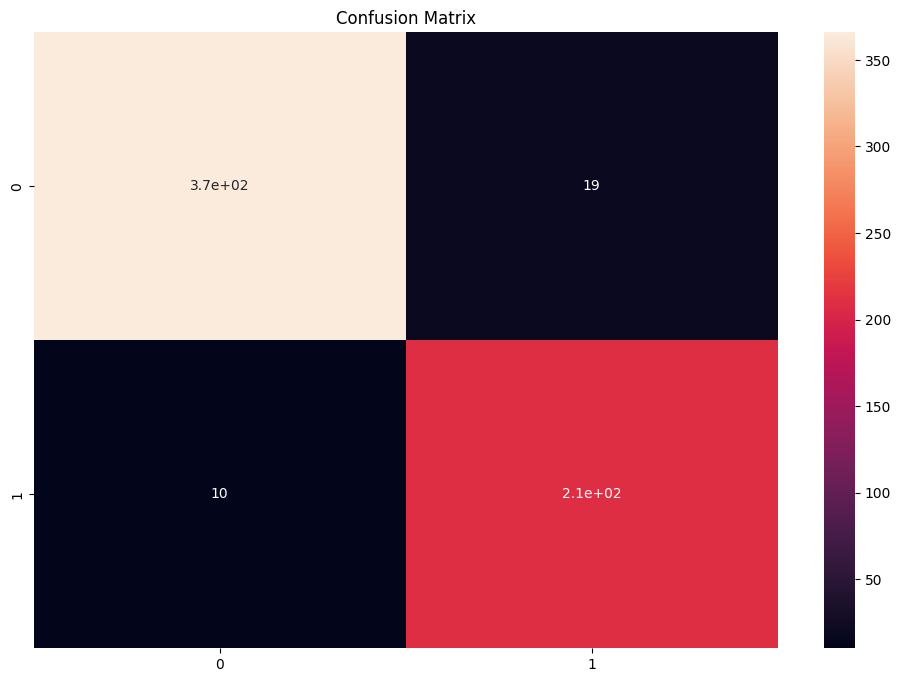

In [20]:
import seaborn as sns

cm=confusion_matrix(y_test,y_pred)
fig=plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
cm

In [21]:
model.save("model_email.keras")
